# 測試

In [7]:
#載入測試用資料
import pandas as pd
import numpy as np
data = pd.read_csv('../data/R公司_人員資料_test_有離職欄位.csv')
data.head()

,員工編號(EmployeeNumber),性別(Gender),年齡(Age),是否為成年人(Over18),婚姻狀態(MaritalStatus),通勤距離(DistanceFromHome),教育程度(Education),教育專業領域(EducationField),部門(Department),職位名稱(JobRole),...,股票選擇權等級(StockOptionLevel),績效評估(PerformanceRating),出差頻率(BusinessTravel),去年訓練時間(TrainingTimesLastYear),工作滿意度(JobSatisfaction),工作環境滿意度(EnvironmentSatisfaction),工作投入(JobInvolvement),工作生活平衡(WorkLifeBalance),人際關係滿意度(RelationshipSatisfaction),離職(Attrition)
0,1469,Male,28,Y,Single,5,3,Medical,Sales,Sales Executive,...,0,3,Travel_Rarely,4,1,4,3,3,4,No
1,250,Female,53,Y,Divorced,13,2,Medical,Research & Development,Manufacturing Director,...,2,3,Travel_Rarely,3,1,4,4,3,3,No
2,1714,Male,24,Y,Married,22,1,Human Resources,Human Resources,Human Resources,...,1,3,Travel_Rarely,2,3,4,1,3,3,Yes
3,86,Male,45,Y,Divorced,7,3,Life Sciences,Research & Development,Research Scientist,...,1,3,Travel_Rarely,2,1,2,3,3,3,No
4,304,Male,36,Y,Single,5,2,Life Sciences,Research & Development,Laboratory Technician,...,0,3,Travel_Rarely,3,2,4,3,4,4,No


In [8]:
# 刪除 price為空值的資料列
data = data.dropna(subset=['離職(Attrition)'])

In [5]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):         
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []
        
    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names       
        
        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                # self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數
            
            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()    
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()    
                    self.scaler[fname].fit(data[[fname]])

            
            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)                    
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)
                
        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()
        
        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])
            
            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:                   
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass                
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)          

In [9]:
# 載入前處理模型並轉換資料
ap = AutoPreprocess.load("C:/DATA/preprocess.bin")
X = ap.transform(data)
y = data['離職(Attrition)'].map({'Yes': 1, 'No': 0})

In [10]:
# 載入模型
f =  open("C:/DATA/model.bin", "rb")
model =  pickle.load(f) 
model

MLPClassifier(hidden_layer_sizes=(200, 50))

驗證組AUC: 0.6076923076923076
驗證組recall: 0.28205128205128205
驗證組precision: 0.39285714285714285


Text(50.722222222222214, 0.5, 'Actual Values ')

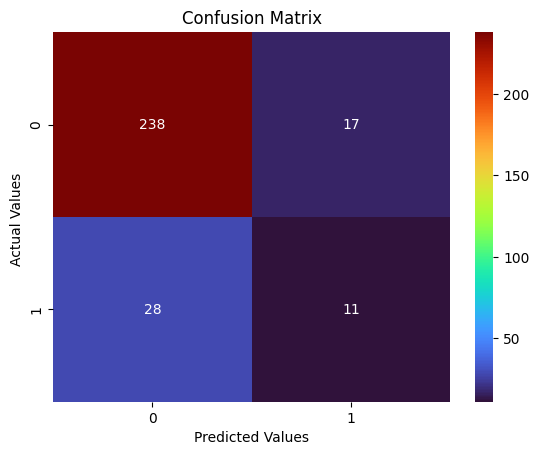

In [15]:
# 驗證模型
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

threshold = 0.5
y_pred = (model.predict_proba(X)[:,1] > threshold).astype('int')
score = roc_auc_score(y, y_pred)
print("驗證組AUC:", score)
score = recall_score(y, y_pred)
print("驗證組recall:", score)
score = precision_score(y, y_pred)
print("驗證組precision:", score)

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = (confusion_matrix(y, y_pred))

fx = sns.heatmap(conf_matrix, annot=True, cmap='turbo', fmt='d')

fx.set_title('Confusion Matrix')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ')

# 推理

In [9]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):         
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []
        
    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names       
        
        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                # self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數
            
            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()    
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()    
                    self.scaler[fname].fit(data[[fname]])

            
            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)                    
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)
                
        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()
        
        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])
            
            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:                   
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass                
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)          

In [14]:
data_dcit = {
    "symboling" : 0,
    "make" : "jaguar",
    "horsepower" : 68.0,
    "Engine-size" : 326
}

In [15]:
# 載入前處理模型並轉換資料
ap = AutoPreprocess.load("C:/DATA/preprocess.bin")
X = ap.transform(data_dcit)

In [16]:
# 載入模型
f =  open("C:/DATA/model.bin", "rb")
model =  pickle.load(f) 
model

RandomForestRegressor()

In [17]:
y_pred = model.predict(X)
y_pred

array([25481.99833333])